In [9]:
import galsim
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from skimage.restoration import (denoise_wavelet, estimate_sigma)
%pylab inline

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from unets.unet import Unet
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from evaluate import keras_psnr, keras_ssim, center_keras_psnr
from learnlets.learnlet_model import Learnlet
from learnlets.keras_utils.normalisation import NormalisationAdjustment

print(tf.test.gpu_device_name())

Populating the interactive namespace from numpy and matplotlib
runstats and/or skimage could not be imported because not installed
/device:GPU:0


/local/home/oa265351/.local/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['shuffle']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [19]:
def mad(x):
    r"""Compute an estimation of the standard deviation 
    of a Gaussian distribution using the robust 
    MAD (Median Absolute Deviation) estimator."""
    return 1.4826*np.median(np.abs(x - np.median(x)))

def STD_estimator(image):
        
    # Calculate window function for estimating the noise
    # We take the center of the image and a large radius to cut all the flux from the star
    window = np.ones(image.shape, dtype=bool)
    
    for coord_x in range(image.shape[0]):
        for coord_y in range(image.shape[1]):
            if np.sqrt((coord_x - 25.5)**2 + (coord_y - 25.5)**2) <= 14 :
                window[coord_x, coord_y] = False
    
    # Calculate noise std dev
    noise_std_dev = mad(image[window])
    
    return noise_std_dev

#estimated_STD = np.array([STD_estimator(_im) for _im in im_train])
#for i in range (len(im_train)):
#    std = STD_estimator(im_train[i,:,:])
#    print(i)
#STD_estimator(im_train[14737,:,:])

#estimated_STD = np.array([STD_estimator(im_train[_i,:,:]) for _i in np.arange(2304)])
#estimated_STD = np.append(estimated_STD, 0)
#estimated_STD_2 = np.array([STD_estimator(im_train[_i,:,:]) for _i in np.arange(29047, 36000)])

#estimated_STD = np.concatenate((estimated_STD, estimated_STD_2))

std_val = np.array([STD_estimator(_im) for _im in im_val])

In [2]:
dataset = np.load('datasets/dataset_eigenpsfs.npy',allow_pickle='TRUE').item()
#dataset2 = np.load('datasets/dataset_gen_test.npy',allow_pickle='TRUE').item()

im_train, im_val, target_train, target_val = train_test_split(dataset['VIGNETS_WITH_NOISE'], dataset['VIGNETS_NOISELESS'], 
                                                              shuffle=False, stratify=None, test_size=0.1, random_state=10)

im_train, target_train = shuffle(im_train, target_train)
#im_val, target_val = shuffle(im_val, target_val)

In [3]:
for i in range (len(im_train)):
    
    norm = np.linalg.norm(im_train[i])
    im_train[i] = im_train[i]/norm
    target_train[i] = target_train[i]/norm
    
coeff = np.zeros(len(im_val)) 

for i in range (len(im_val)):
    
    coeff[i] = np.linalg.norm(im_val[i])
    im_val[i] = im_val[i]/coeff[i]
    target_val[i] = target_val[i]/coeff[i]

In [15]:
im_train = (tf.reshape(tf.convert_to_tensor(im_train), [len(im_train), 51, 51, 1]))
im_val = (tf.reshape(tf.convert_to_tensor(im_val), [len(im_val), 51, 51, 1]))
target_train = tf.reshape(tf.convert_to_tensor(target_train), [len(im_train), 51, 51, 1])
target_val = tf.reshape(tf.convert_to_tensor(target_val), [len(im_val), 51, 51, 1])

estimated_STD = np.zeros(len(im_train))

In [17]:
run_params = {
    'denoising_activation': 'dynamic_soft_thresholding',
    'learnlet_analysis_kwargs':{
        'n_tiling': 256, 
        'mixing_details': False,    
        'skip_connection': True,
    },
    'learnlet_synthesis_kwargs': {
        'res': True,
    },
    'threshold_kwargs':{
        'noise_std_norm': True,
    },
#     'wav_type': 'bior',
    'n_scales': 5,
    'n_reweights_learn': 1,
    'clip': False,
}

In [18]:
model = keras.models.load_model('saved_unets')


learnlets = Learnlet(**run_params)
learnlets.compile(optimizer=Adam(lr=1e-3),
    loss='mse',
    metrics=[keras_psnr, keras_ssim, center_keras_psnr],
)
learnlets.fit(
    (im_train, estimated_STD), 
    target_train,
    validation_data=((im_val, std_val), target_val),
    steps_per_epoch=1, 
    epochs=1,
    batch_size=12,)
learnlets.load_weights("saved_learnlets/cp.h5")

1/1 [==============================] - 6s 6s/step - loss: 4.1130e-04 - keras_psnr: 33.8635 - keras_ssim: 0.8704 - center_keras_psnr: 31.5407 - val_loss: 4.6932e-04 - val_keras_psnr: 33.4323 - val_keras_ssim: 0.6139 - val_center_keras_psnr: 31.4227


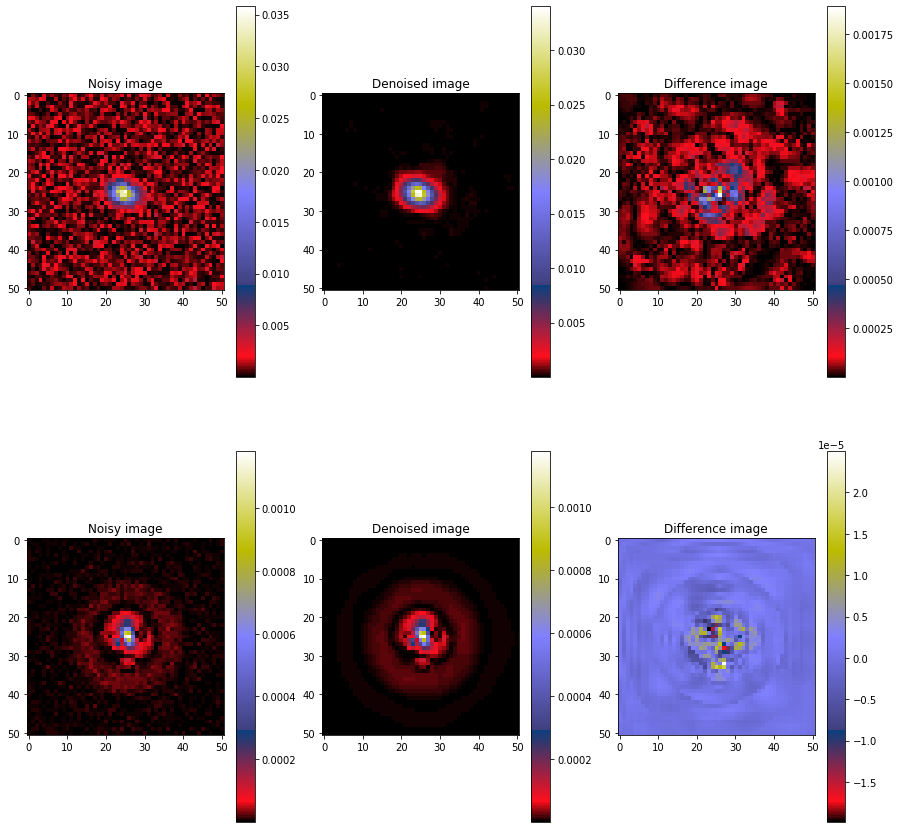

In [20]:
ind=340
deud=1400
one_star_noiseless = tf.reshape(learnlets.predict((im_val, std_val))[ind,:,:], [51, 51])*coeff[ind]
one_star_truth = tf.reshape(tf.convert_to_tensor(target_val[ind,:,:]), [51, 51])*coeff[ind]
one_star_noiseless = tf.cast(one_star_noiseless, one_star_truth.dtype)
one_star_noise = tf.reshape(tf.convert_to_tensor(im_val[ind,:,:]), [51, 51])*coeff[ind]
second_star_noiseless = tf.reshape(learnlets.predict((im_val, std_val))[deud,:,:], [51, 51])*coeff[deud]
second_star_truth = tf.reshape(tf.convert_to_tensor(target_val[deud,:,:]), [51, 51])*coeff[deud]
second_star_noiseless = tf.cast(second_star_noiseless, second_star_truth.dtype)
second_star_noise = tf.reshape(tf.convert_to_tensor(im_val[deud,:,:]), [51, 51])*coeff[deud]



fig = plt.figure(num=0, figsize=(15,15))
plt.title('U-Nets Denoising')
subplot(231)
title('Noisy image')
imshow(abs(one_star_noise), interpolation='None',cmap='gist_stern');colorbar()
subplot(232)
#imshow(one_star_noiseless-one_star_truth, interpolation='None',cmap='gist_stern');colorbar()
imshow(abs(one_star_noiseless), interpolation='None',cmap='gist_stern');colorbar()
title('Denoised image')
subplot(233)
imshow(abs(one_star_truth-one_star_noiseless), interpolation='None',cmap='gist_stern');colorbar()
title('Difference image')
subplot(234)
title('Noisy image')
imshow(abs(second_star_noise), interpolation='None',cmap='gist_stern');colorbar()
subplot(235)
#imshow(second_star_noiseless-second_star_truth, interpolation='None',cmap='gist_stern');colorbar()
imshow(abs(second_star_noiseless), interpolation='None',cmap='gist_stern');colorbar()
title('Denoised image')
subplot(236)
imshow(abs(second_star_truth)-abs(second_star_noiseless), interpolation='None', cmap='gist_stern');colorbar()
title('Difference image')
show()

